In [1]:
from datetime import datetime
from pprint import pprint
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.oauth2 import service_account


# 1. Lectura de los datos de la base de datos MongoDB

Lectura de credenciales de MongoDB

In [2]:
with open('../Credentials/MONGO.json') as f:
    credenciales_acceso_mongodb = f.readlines()

Conexion a la base de datos de MongoDB

In [3]:
DB_NAME = "sample_analytics"

COLLECTION_accounts = "accounts"
COLLECTION_customers = "customers"
COLLECTION_transactions = "transactions"


client = pymongo.MongoClient(credenciales_acceso_mongodb, server_api = pymongo.server_api.ServerApi('1'))

db = client[DB_NAME]

col_accounts = db[COLLECTION_accounts]
col_customers = db[COLLECTION_customers]
col_transactions = db[COLLECTION_transactions]

In [4]:
pprint(col_accounts.find_one({}))

{'_id': ObjectId('5ca4bbc7a2dd94ee58162392'),
 'account_id': 794875,
 'limit': 9000,
 'products': ['InvestmentFund', 'InvestmentStock']}


In [5]:
pprint(col_customers.find_one({}))

{'_id': ObjectId('5ca4bbcea2dd94ee58162a6a'),
 'accounts': [462501, 228290, 968786, 515844, 377292],
 'address': '55711 Janet Plaza Apt. 865\nChristinachester, CT 62716',
 'birthdate': datetime.datetime(1988, 6, 20, 22, 15, 34),
 'email': 'timothy78@hotmail.com',
 'name': 'Katherine David',
 'tier_and_details': {},
 'username': 'hillrachel'}


# 2. ETL

## 2.1. ¿Cuántas transacciones se ejecutan cada mes y en qué meses del año se realizan más transacciones?

### 2.1.1. Ejecución del query en Mongo que traiga los datos que necesitamos

In [6]:
transactions_dates = list(
    
    col_transactions.aggregate([
        
        {"$unwind": "$transactions"},
        
        { "$group": {
            
            "_id": {
                "$dateToString": {
                  "date": "$transactions.date",
                  "format": "%m"
                }
            },
            "Cantidad_de_transacciones": {
                "$sum": "$transactions.amount"
            },
            
        }},
        
        { "$sort" : { "Cantidad_de_transacciones" : -1 } }
        
    ])
)

In [7]:
pprint(transactions_dates)

[{'Cantidad_de_transacciones': 40774372, '_id': '12'},
 {'Cantidad_de_transacciones': 38667152, '_id': '10'},
 {'Cantidad_de_transacciones': 38562502, '_id': '08'},
 {'Cantidad_de_transacciones': 37625695, '_id': '06'},
 {'Cantidad_de_transacciones': 36965156, '_id': '11'},
 {'Cantidad_de_transacciones': 36645459, '_id': '07'},
 {'Cantidad_de_transacciones': 36600639, '_id': '03'},
 {'Cantidad_de_transacciones': 36474028, '_id': '09'},
 {'Cantidad_de_transacciones': 35700475, '_id': '05'},
 {'Cantidad_de_transacciones': 35170971, '_id': '04'},
 {'Cantidad_de_transacciones': 35160587, '_id': '01'},
 {'Cantidad_de_transacciones': 31480521, '_id': '02'}]


### 2.1.2. Tranformación del resultado a dataframe

In [8]:
transactiones_mes_df = pd.json_normalize(transactions_dates).rename(columns = {"_id": "Mes"})
transactiones_mes_df

,Mes,Cantidad_de_transacciones
0,12,40774372
1,10,38667152
2,08,38562502
3,06,37625695
4,11,36965156
5,07,36645459
6,03,36600639
7,09,36474028
8,05,35700475
9,04,35170971


In [9]:
def cambiar_nombre_mes(input_mes):
    
    meses = {
        1: "Enero",
        2: "Febrero",
        3: "Marzo",
        4: "Abril",
        5: "Mayo",
        6: "Junio",
        7: "Julio",
        8: "Agosto",
        9: "Septiembre",
        10: "Octubre",
        11: "Noviembre",
        12: "Diciembre"
    }
    
    return meses[int(input_mes)]

In [10]:
transactiones_mes_df['Mes'] = transactiones_mes_df['Mes'].apply(cambiar_nombre_mes)
transactiones_mes_df

,Mes,Cantidad_de_transacciones
0,Diciembre,40774372
1,Octubre,38667152
2,Agosto,38562502
3,Junio,37625695
4,Noviembre,36965156
5,Julio,36645459
6,Marzo,36600639
7,Septiembre,36474028
8,Mayo,35700475
9,Abril,35170971


<AxesSubplot:xlabel='Mes', ylabel='Cantidad_de_transacciones'>

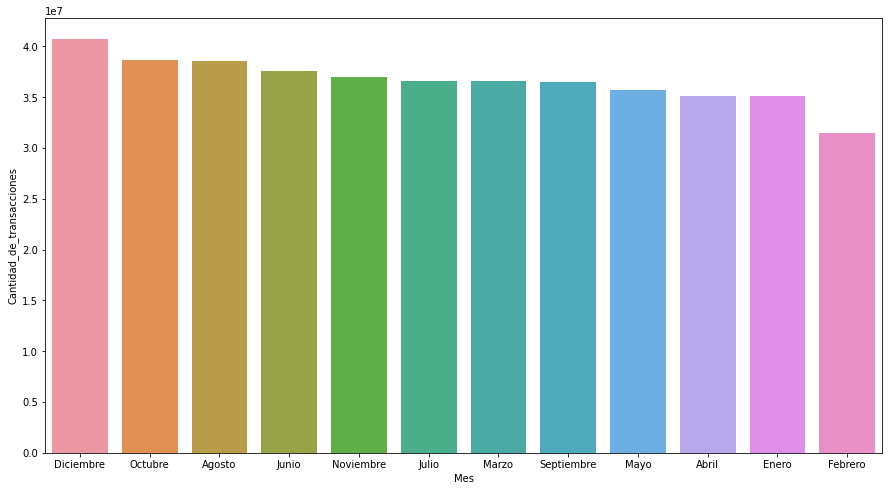

In [11]:
plt.figure(figsize=(15,8))
sns.barplot(data=transactiones_mes_df, x="Mes", y="Cantidad_de_transacciones")


In [13]:
transactiones_mes_df.to_csv('../Data/transacciones_mes.csv', encoding='utf-8', index=False)

### 2.1.3. Carga de los datos a BigQuery

In [72]:
credentials_bigquery = service_account.Credentials.from_service_account_file("../Credentials/javeriana-dataprep.json", scopes = ["https://www.googleapis.com/auth/cloud-platform"])

client_bigquery = bigquery.Client(credentials = credentials_bigquery, project = credentials_bigquery.project_id)

In [79]:
job_config = bigquery.LoadJobConfig(
    schema = [
        bigquery.SchemaField("Mes", bigquery.enums.SqlTypeNames.STRING),
        bigquery.SchemaField("Cantidad_de_transacciones", bigquery.enums.SqlTypeNames.INT64)
    ],
    write_disposition = "WRITE_TRUNCATE",
)

BQ_TABLE_NAME = "dataprep.cantidad_de_transacciones_hechas_por_mes"


job = client_bigquery.load_table_from_dataframe(
    transactiones_mes_df, BQ_TABLE_NAME, job_config = job_config
)

job.result()

LoadJob<project=javeriana-dataprep, location=us-central1, id=8b63202e-4285-4d78-bb48-5a03d79f4547>

In [81]:
query = """SELECT * FROM `dataprep.cantidad_de_transacciones_hechas_por_mes`"""

pd.read_gbq(query, credentials = credentials_bigquery)

,Mes,Cantidad_de_transacciones
0,Diciembre,40774372
1,Octubre,38667152
2,Agosto,38562502
3,Junio,37625695
4,Noviembre,36965156
5,Julio,36645459
6,Marzo,36600639
7,Septiembre,36474028
8,Mayo,35700475
9,Abril,35170971


## 2.2. ¿Como evoluciona la cantidad de operaciones de venta con las de compra a través del tiempo?

### 2.2.1. Ejecución del query en Mongo que traiga los datos que necesitamos

In [14]:
buy_series = list(
    
    col_transactions.aggregate([
        
        {"$unwind": "$transactions"},
        
        {"$match": { "transactions.transaction_code" : "buy" }},
        
        { "$group": {
            
            "_id": {
                "$dateToString": {
                  "date": "$transactions.date",
                  "format": "%Y-%m-%d"
                }
            },
            "Cantidad_de_compras": {
                "$sum": "$transactions.amount"
            },
            
        }}
        
    ])
)

In [15]:
buy_series[0:10]

[{'_id': '1996-01-16', 'Cantidad_de_compras': 320},
 {'_id': '2005-04-14', 'Cantidad_de_compras': 38901},
 {'_id': '2008-05-28', 'Cantidad_de_compras': 23741},
 {'_id': '1998-06-03', 'Cantidad_de_compras': 18974},
 {'_id': '2010-07-15', 'Cantidad_de_compras': 59497},
 {'_id': '2012-06-12', 'Cantidad_de_compras': 61689},
 {'_id': '2014-10-24', 'Cantidad_de_compras': 100668},
 {'_id': '1997-06-26', 'Cantidad_de_compras': 9132},
 {'_id': '2007-05-18', 'Cantidad_de_compras': 11872},
 {'_id': '1993-08-13', 'Cantidad_de_compras': 695}]

In [16]:
sell_series = list(
    
    col_transactions.aggregate([
        
        {"$unwind": "$transactions"},
        
        {"$match": { "transactions.transaction_code" : "sell" }},
        
        { "$group": {
            
            "_id": {
                "$dateToString": {
                  "date": "$transactions.date",
                  "format": "%Y-%m-%d"
                }
            },
            "Cantidad_de_ventas": {
                "$sum": "$transactions.amount"
            },
            
        }}
        
    ])
)

In [17]:
sell_series[0:10]

[{'_id': '1975-01-22', 'Cantidad_de_ventas': 7796},
 {'_id': '2005-04-14', 'Cantidad_de_ventas': 15617},
 {'_id': '2008-05-28', 'Cantidad_de_ventas': 40361},
 {'_id': '1998-06-03', 'Cantidad_de_ventas': 1617},
 {'_id': '1974-06-04', 'Cantidad_de_ventas': 2769},
 {'_id': '2010-07-15', 'Cantidad_de_ventas': 51891},
 {'_id': '2012-06-12', 'Cantidad_de_ventas': 31215},
 {'_id': '1973-10-15', 'Cantidad_de_ventas': 8873},
 {'_id': '2014-10-24', 'Cantidad_de_ventas': 118447},
 {'_id': '2007-05-18', 'Cantidad_de_ventas': 10799}]

### 2.2.2. Tranformación del resultado a dataframe

In [18]:
compras_df = pd.json_normalize(buy_series).rename(columns = {"_id": "Fecha"})
compras_df['Fecha'] = pd.to_datetime(compras_df['Fecha'], format='%Y-%m-%d')
compras_df = compras_df.sort_values(by=['Fecha'])
compras_df

,Fecha,Cantidad_de_compras
856,1962-05-22,6360
1519,1962-06-21,5024
5002,1963-01-23,8064
1218,1963-02-11,5303
2133,1963-03-28,6116
...,...,...
4483,2017-01-03,118655
4868,2017-01-04,98953
7400,2017-01-05,128604
2033,2017-01-06,166431


In [19]:
ventas_df = pd.json_normalize(sell_series).rename(columns = {"_id": "Fecha"})
ventas_df['Fecha'] = pd.to_datetime(ventas_df['Fecha'], format='%Y-%m-%d')
ventas_df = ventas_df.sort_values(by=['Fecha'])
ventas_df

,Fecha,Cantidad_de_ventas
3545,1962-03-08,727
3082,1962-11-09,5573
3714,1963-02-21,7700
2655,1963-05-24,8932
328,1963-07-25,547
...,...,...
4468,2017-01-03,159360
4868,2017-01-04,113118
7394,2017-01-05,99403
2012,2017-01-06,143189


In [20]:
series_compras_ventas_df = pd.concat([compras_df.set_index('Fecha'), ventas_df.set_index('Fecha')], axis=1, join="inner").reset_index()
series_compras_ventas_df

,Fecha,Cantidad_de_compras,Cantidad_de_ventas
0,1967-04-05,5150,1269
1,1968-12-26,3997,103
2,1969-04-18,1912,1289
3,1970-08-11,1391,7381
4,1972-04-17,2378,4218
...,...,...,...
6283,2017-01-03,118655,159360
6284,2017-01-04,98953,113118
6285,2017-01-05,128604,99403
6286,2017-01-06,166431,143189


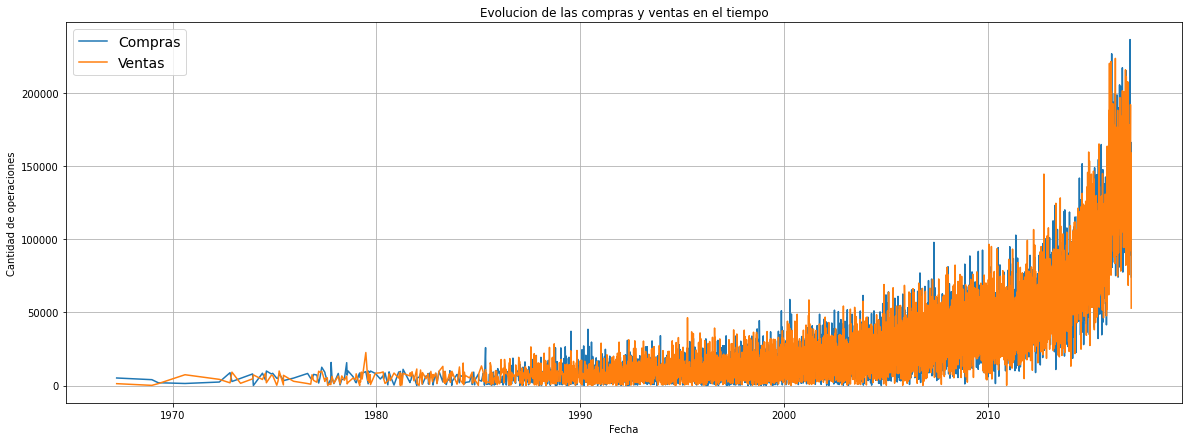

In [21]:
plt.figure(figsize=(20, 7))

plt.plot(series_compras_ventas_df['Fecha'], series_compras_ventas_df['Cantidad_de_compras'], label="Compras")
plt.plot(series_compras_ventas_df['Fecha'], series_compras_ventas_df['Cantidad_de_ventas'], label="Ventas")

plt.xlabel("Fecha")
plt.ylabel("Cantidad de operaciones")
plt.legend(fontsize=14)
plt.title('Evolucion de las compras y ventas en el tiempo')
plt.grid(True)
plt.show();

In [22]:
series_compras_ventas_df.to_csv('../Data/series_compras_ventas.csv', encoding='utf-8', index=False)

### 2.2.3. Carga de los datos a BigQuery

In [122]:
job_config = bigquery.LoadJobConfig(
    schema = [
        bigquery.SchemaField("Fecha", bigquery.enums.SqlTypeNames.TIMESTAMP),
        bigquery.SchemaField("Cantidad_de_compras", bigquery.enums.SqlTypeNames.INT64),
        bigquery.SchemaField("Cantidad_de_ventas", bigquery.enums.SqlTypeNames.INT64)
    ],
    write_disposition = "WRITE_TRUNCATE",
)

BQ_TABLE_NAME = "dataprep.serie_de_tiempo_de_compras_y_ventas"


job = client_bigquery.load_table_from_dataframe(
    series_compras_ventas_df, BQ_TABLE_NAME, job_config = job_config
)

job.result()

LoadJob<project=javeriana-dataprep, location=us-central1, id=85327194-0763-4df9-a985-6ede66b09e3d>

In [123]:
query = """SELECT * FROM `dataprep.serie_de_tiempo_de_compras_y_ventas`"""

pd.read_gbq(query, credentials = credentials_bigquery)

,Fecha,Cantidad_de_compras,Cantidad_de_ventas
0,2011-04-28 00:00:00+00:00,65536,36278
1,1999-06-15 00:00:00+00:00,4608,22776
2,1988-02-19 00:00:00+00:00,5120,1350
3,1995-11-21 00:00:00+00:00,5632,3885
4,1994-09-20 00:00:00+00:00,8448,10334
...,...,...,...
6283,2015-07-24 00:00:00+00:00,96511,110957
6284,2006-02-17 00:00:00+00:00,34815,14080
6285,2012-08-13 00:00:00+00:00,42495,58283
6286,2013-08-21 00:00:00+00:00,64511,56067


## 2.3. ¿Cuáles son los tipos de cuentas más usuales entre los clientes?

### 2.3.1. Ejecución del query en Mongo que traiga los datos que necesitamos

In [23]:
tipos_de_cuentas = list(
    
    col_accounts.aggregate([
        
        {"$unwind": "$products"},
        
        {"$group" : { "_id" : '$products', "Cantidad" : {"$sum" : 1}}},
        
        { "$sort" : { "Cantidad" : -1 }}
        
    ])
)

In [24]:
tipos_de_cuentas

[{'_id': 'InvestmentStock', 'Cantidad': 1746},
 {'_id': 'CurrencyService', 'Cantidad': 742},
 {'_id': 'Brokerage', 'Cantidad': 741},
 {'_id': 'InvestmentFund', 'Cantidad': 728},
 {'_id': 'Commodity', 'Cantidad': 720},
 {'_id': 'Derivatives', 'Cantidad': 706}]

### 2.3.2. Tranformación del resultado a dataframe

In [25]:
tipos_cuentas_df = pd.json_normalize(tipos_de_cuentas).rename(columns = {"_id": "Tipo_de_cuenta"})
tipos_cuentas_df

,Tipo_de_cuenta,Cantidad
0,InvestmentStock,1746
1,CurrencyService,742
2,Brokerage,741
3,InvestmentFund,728
4,Commodity,720
5,Derivatives,706


<AxesSubplot:xlabel='Tipo_de_cuenta', ylabel='Cantidad'>

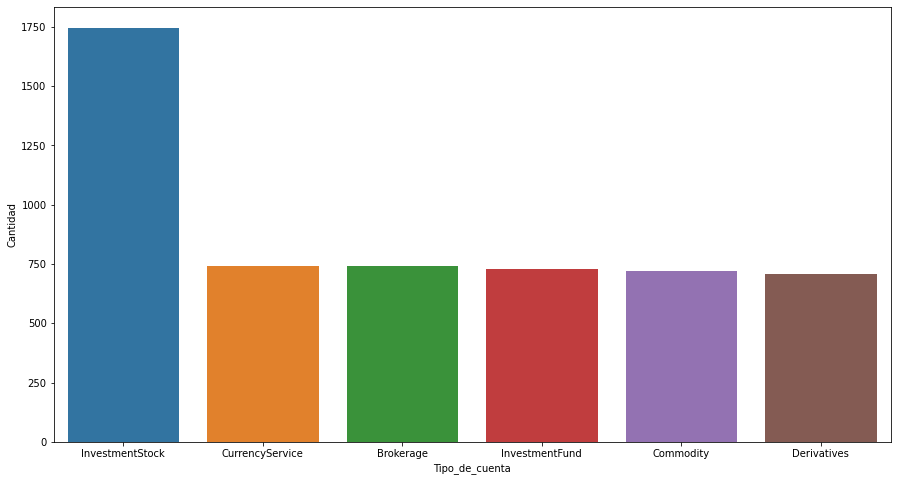

In [26]:
plt.figure(figsize=(15,8))
sns.barplot(data=tipos_cuentas_df, x="Tipo_de_cuenta", y="Cantidad")

In [27]:
tipos_cuentas_df.to_csv('../Data/tipos_cuentas.csv', encoding='utf-8', index=False)

### 2.3.3. Carga de los datos a BigQuery

In [139]:
job_config = bigquery.LoadJobConfig(
    schema = [
        bigquery.SchemaField("Tipo_de_cuenta", bigquery.enums.SqlTypeNames.STRING),
        bigquery.SchemaField("Cantidad", bigquery.enums.SqlTypeNames.INT64)
    ],
    write_disposition = "WRITE_TRUNCATE",
)

BQ_TABLE_NAME = "dataprep.cantidad_de_tipos_de_cuentas"


job = client_bigquery.load_table_from_dataframe(
    tipos_cuentas_df, BQ_TABLE_NAME, job_config = job_config
)

job.result()

LoadJob<project=javeriana-dataprep, location=us-central1, id=a3721e35-339d-4415-8d16-300f4d8bb43c>

In [140]:
query = """SELECT * FROM `dataprep.cantidad_de_tipos_de_cuentas`"""

pd.read_gbq(query, credentials = credentials_bigquery)

,Tipo_de_cuenta,Cantidad
0,InvestmentStock,1746
1,CurrencyService,742
2,Brokerage,741
3,InvestmentFund,728
4,Commodity,720
5,Derivatives,706
